# Decision Tree Classification with Lag/MA Features and Hyperparameter Tuning

This notebook trains **Decision Tree classifiers** to predict discretised CO(GT) levels for
four horizons (1, 6, 12, 24 hours ahead), using:

- Time-based features (hour, weekday, month)
- Lag features of CO(GT): 1, 6, 12, 24 hours
- Moving averages of CO(GT): 3, 6, 12, 24 hours

It also performs **manual hyperparameter tuning** over `max_depth` and `min_samples_leaf`
using the validation set, and then retrains on train+val and evaluates on the test set.


## 0. Imports and configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 120

HORIZONS = [1, 6, 12, 24]
TARGET = "CO(GT)"


## 1. Load train / validation / test sets

In [2]:
train_path = "data/splits/airq_train.csv"
val_path   = "data/splits/airq_val.csv"
test_path  = "data/splits/airq_test.csv"

train = pd.read_csv(train_path, parse_dates=["timestamp"])
val   = pd.read_csv(val_path,   parse_dates=["timestamp"])
test  = pd.read_csv(test_path,  parse_dates=["timestamp"])

print("Train shape:", train.shape)
print("Val shape:  ", val.shape)
print("Test shape: ", test.shape)

display(train.head())


Train shape: (6550, 14)
Val shape:   (1404, 14)
Test shape:  (1403, 14)


,timestamp,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,150.0,11.9,166.0,113.0,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,112.0,9.4,103.0,92.0,1292.0,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,88.0,9.0,131.0,114.0,1402.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,80.0,9.2,172.0,122.0,1376.0,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,51.0,6.5,131.0,116.0,1272.0,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888


## 2. Drop `NMHC(GT)` and add basic time features

In [ ]:
for df in (train, val, test):
   
    if "NMHC(GT)" in df.columns:
        df.drop(columns=["NMHC(GT)"], inplace=True)
    
    df["hour"] = df["timestamp"].dt.hour
    df["weekday"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month

print(train.dtypes)


timestamp        datetime64[ns]
CO(GT)                  float64
C6H6(GT)                float64
NOx(GT)                 float64
NO2(GT)                 float64
PT08.S1(CO)             float64
PT08.S2(NMHC)           float64
PT08.S3(NOx)            float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
hour                      int32
weekday                   int32
month                     int32
dtype: object


## 3. Add lag features and moving averages for CO(GT)

In [4]:
def add_lag_ma(df: pd.DataFrame,
               base_cols,
               lags,
               mas):
    """Add lag features and moving averages for selected columns.

    - For each column c in base_cols:
        c_lag_h : value at t-h
        c_ma_w  : moving average over past w steps (including current)
    """
    df = df.sort_values("timestamp").copy()
    for col in base_cols:
        for h in lags:
            df[f"{col}_lag_{h}"] = df[col].shift(h)
        for w in mas:
            df[f"{col}_ma_{w}"] = df[col].rolling(window=w).mean()
    return df

lag_hours = [1, 6, 12, 24]
ma_windows = [3, 6, 12, 24]
base_cols = [TARGET]

train = add_lag_ma(train, base_cols, lag_hours, ma_windows)
val   = add_lag_ma(val,   base_cols, lag_hours, ma_windows)
test  = add_lag_ma(test,  base_cols, lag_hours, ma_windows)

print("Train columns after lag/MA:")
print(train.columns)


Train columns after lag/MA:
Index(['timestamp', 'CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S1(CO)',
       'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T',
       'RH', 'AH', 'hour', 'weekday', 'month', 'CO(GT)_lag_1', 'CO(GT)_lag_6',
       'CO(GT)_lag_12', 'CO(GT)_lag_24', 'CO(GT)_ma_3', 'CO(GT)_ma_6',
       'CO(GT)_ma_12', 'CO(GT)_ma_24'],
      dtype='object')


## 4. Construct horizon targets (1h, 6h, 12h, 24h ahead)

In [ ]:
def discretise_co(values: pd.Series) -> pd.Series:
    
    bins = [-np.inf, 1.5, 2.5, np.inf]
    labels = ["low", "mid", "high"]
    return pd.cut(values, bins=bins, labels=labels)


def add_targets(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values("timestamp").copy()
    for h in HORIZONS:
        shifted = df[TARGET].shift(-h)
        df[f"y_{h}h"] = discretise_co(shifted)
    return df

train = add_targets(train)
val   = add_targets(val)
test  = add_targets(test)

print(train[["timestamp"] + [f"y_{h}h" for h in HORIZONS]].head())


            timestamp y_1h y_6h y_12h y_24h
0 2004-03-10 18:00:00  mid  low   low  high
1 2004-03-10 19:00:00  mid  low   low  high
2 2004-03-10 20:00:00  mid  low   mid  high
3 2004-03-10 21:00:00  mid  low   mid  high
4 2004-03-10 22:00:00  low  NaN   mid   low


## 5. Helper: build X / y for a given horizon

In [ ]:
def build_xy(df: pd.DataFrame, h: int):
  
    y_col = f"y_{h}h"
    df2 = df.dropna(subset=[y_col]).copy()
    y = df2[y_col]

    drop_cols = ["timestamp"] + [f"y_{k}h" for k in HORIZONS]
    feature_cols = [c for c in df2.columns if c not in drop_cols]
    X = df2[feature_cols]

    return X, y, feature_cols

X_train_1h, y_train_1h, feat_cols_1h = build_xy(train, 1)
print("1h horizon – X_train shape:", X_train_1h.shape)
print("Number of features:", len(feat_cols_1h))


1h horizon – X_train shape: (5066, 23)
Number of features: 23


## 6. Baseline Decision Tree run (fixed hyperparameters)

In [7]:
def run_model_fixed(h: int,
                    depth: int = 7,
                    leaf: int = 30):
    print("=" * 60)
    print(f"Horizon: {h} hour(s) ahead – fixed params (depth={depth}, leaf={leaf})")

    Xtr, ytr, _ = build_xy(train, h)
    Xv, yv, _   = build_xy(val,   h)
    Xte, yte, _ = build_xy(test,  h)

    pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("clf", DecisionTreeClassifier(max_depth=depth,
                                        min_samples_leaf=leaf,
                                        random_state=42)),
    ])

    pipe.fit(Xtr, ytr)
    val_acc = accuracy_score(yv, pipe.predict(Xv))
    test_pred = pipe.predict(Xte)
    test_acc = accuracy_score(yte, test_pred)

    co_now = test.loc[Xte.index, TARGET]
    baseline_pred = discretise_co(co_now)
    mask = baseline_pred.notna()
    baseline_acc = accuracy_score(yte[mask], baseline_pred[mask])

    print(f"Val accuracy (fixed): {val_acc:.4f}")
    print(f"Test accuracy (Decision Tree, fixed): {test_acc:.4f}")
    print(f"Test accuracy (naïve baseline):        {baseline_acc:.4f}")

for h in HORIZONS:
    run_model_fixed(h)


Horizon: 1 hour(s) ahead – fixed params (depth=7, leaf=30)
Val accuracy (fixed): 0.6861
Test accuracy (Decision Tree, fixed): 0.7595
Test accuracy (naïve baseline):        0.7519
Horizon: 6 hour(s) ahead – fixed params (depth=7, leaf=30)
Val accuracy (fixed): 0.5204
Test accuracy (Decision Tree, fixed): 0.5640
Test accuracy (naïve baseline):        0.3725
Horizon: 12 hour(s) ahead – fixed params (depth=7, leaf=30)
Val accuracy (fixed): 0.5540
Test accuracy (Decision Tree, fixed): 0.6319
Test accuracy (naïve baseline):        0.4009
Horizon: 24 hour(s) ahead – fixed params (depth=7, leaf=30)
Val accuracy (fixed): 0.5347
Test accuracy (Decision Tree, fixed): 0.5441
Test accuracy (naïve baseline):        0.6275


## 7. Hyperparameter tuning on validation set
We search over a small grid of `max_depth` and `min_samples_leaf` and select
the combination that yields the best **validation accuracy** for each horizon.


In [8]:
param_grid_depth = [5, 7, 9, 11]
param_grid_leaf = [10, 20, 30, 50]

def tune_params_for_horizon(h: int):
    print("\n" + "-" * 60)
    print(f"Hyperparameter tuning for horizon {h}h")

    Xtr, ytr, _ = build_xy(train, h)
    Xv, yv, _   = build_xy(val,   h)

    best_acc = -1.0
    best_params = None

    for d in param_grid_depth:
        for leaf in param_grid_leaf:
            pipe = Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("clf", DecisionTreeClassifier(max_depth=d,
                                                min_samples_leaf=leaf,
                                                random_state=42)),
            ])
            pipe.fit(Xtr, ytr)
            val_pred = pipe.predict(Xv)
            acc = accuracy_score(yv, val_pred)
            print(f"max_depth={d:2d}, min_samples_leaf={leaf:2d} -> val_acc={acc:.4f}")
            if acc > best_acc:
                best_acc = acc
                best_params = (d, leaf)

    print(f"--> Best params for {h}h: max_depth={best_params[0]}, "
          f"min_samples_leaf={best_params[1]}, val_acc={best_acc:.4f}")
    return best_params

best_params = {}
for h in HORIZONS:
    best_params[h] = tune_params_for_horizon(h)

print("\nSummary of best params per horizon:")
for h in HORIZONS:
    d, leaf = best_params[h]
    print(f"  h={h}h -> max_depth={d}, min_samples_leaf={leaf}")



------------------------------------------------------------
Hyperparameter tuning for horizon 1h
max_depth= 5, min_samples_leaf=10 -> val_acc=0.6861
max_depth= 5, min_samples_leaf=20 -> val_acc=0.6869
max_depth= 5, min_samples_leaf=30 -> val_acc=0.6829
max_depth= 5, min_samples_leaf=50 -> val_acc=0.7307
max_depth= 7, min_samples_leaf=10 -> val_acc=0.6999
max_depth= 7, min_samples_leaf=20 -> val_acc=0.7064
max_depth= 7, min_samples_leaf=30 -> val_acc=0.6861
max_depth= 7, min_samples_leaf=50 -> val_acc=0.7299
max_depth= 9, min_samples_leaf=10 -> val_acc=0.7137
max_depth= 9, min_samples_leaf=20 -> val_acc=0.7032
max_depth= 9, min_samples_leaf=30 -> val_acc=0.6869
max_depth= 9, min_samples_leaf=50 -> val_acc=0.7299
max_depth=11, min_samples_leaf=10 -> val_acc=0.7097
max_depth=11, min_samples_leaf=20 -> val_acc=0.7048
max_depth=11, min_samples_leaf=30 -> val_acc=0.6869
max_depth=11, min_samples_leaf=50 -> val_acc=0.7299
--> Best params for 1h: max_depth=5, min_samples_leaf=50, val_acc=0.7

## 8. Final models: train on train+val with tuned params, evaluate on test


Final model for horizon 1h (max_depth=5, min_samples_leaf=50)
Test accuracy (tuned): 0.7332
Test accuracy (naïve baseline): 0.7519

Classification report (tuned model, test set):
              precision    recall  f1-score   support

        high      0.728     0.786     0.756       341
         low      0.847     0.819     0.833       651
         mid      0.547     0.539     0.543       380

    accuracy                          0.733      1372
   macro avg      0.707     0.715     0.711      1372
weighted avg      0.734     0.733     0.733      1372



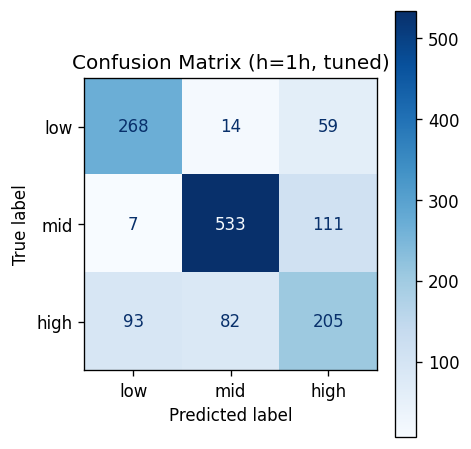

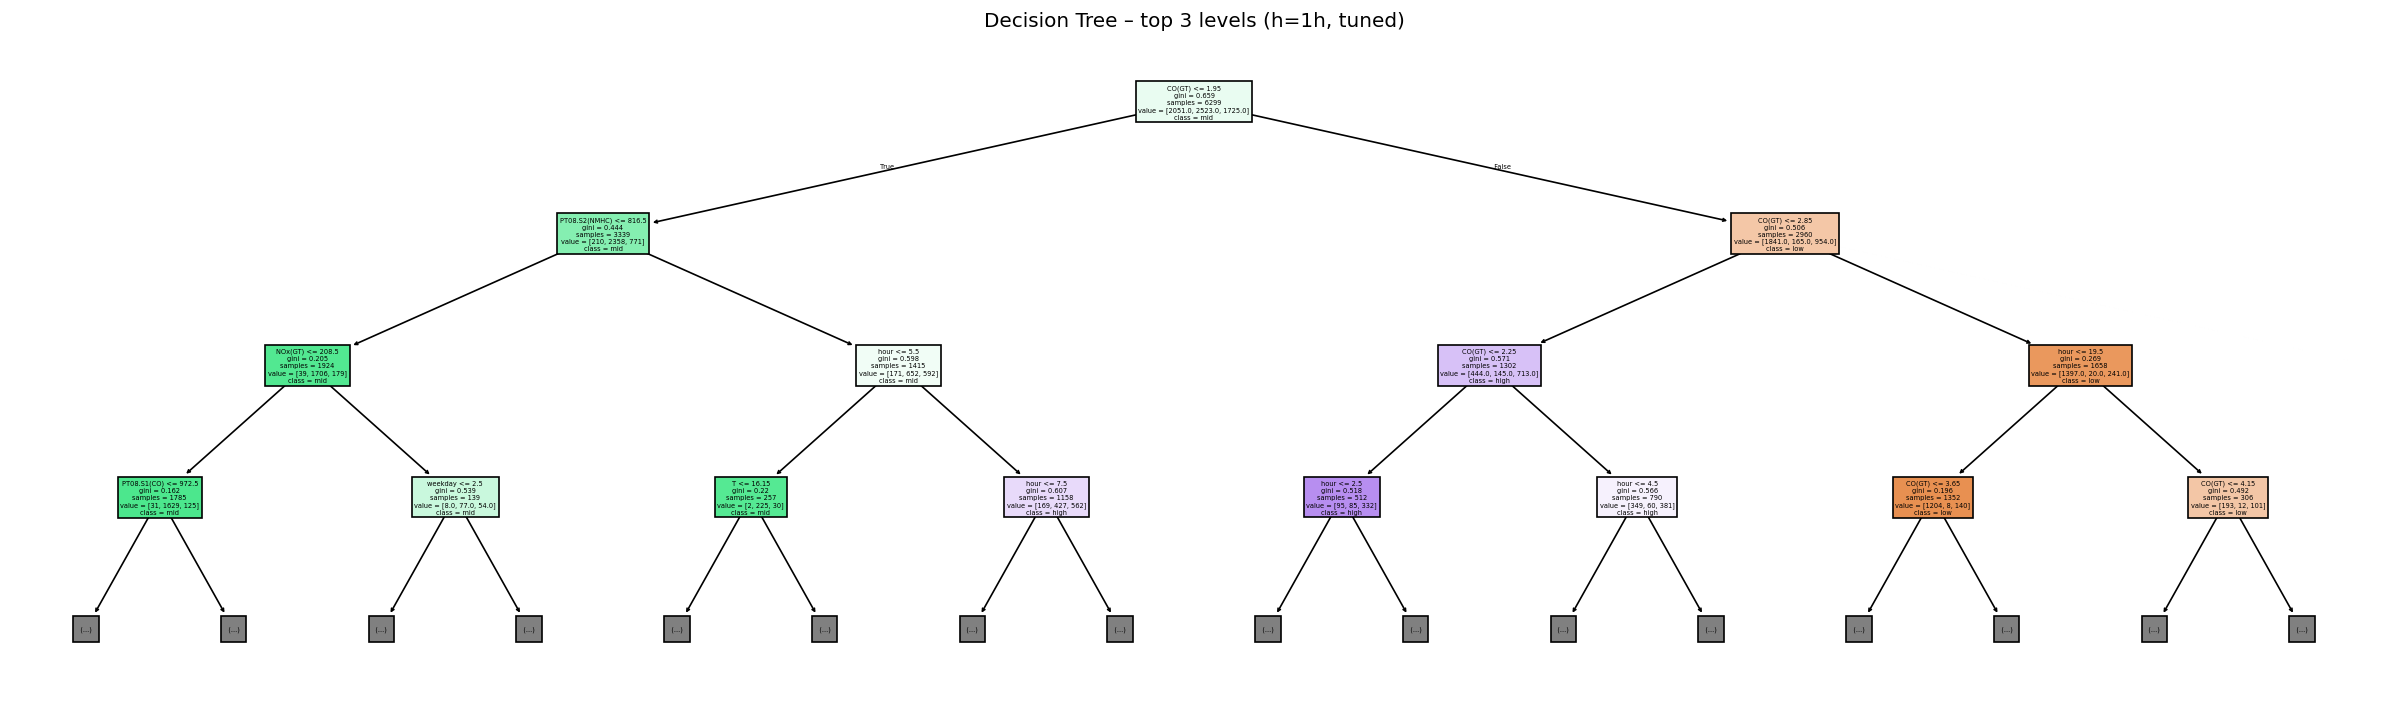


Final model for horizon 6h (max_depth=9, min_samples_leaf=50)
Test accuracy (tuned): 0.5874
Test accuracy (naïve baseline): 0.3725

Classification report (tuned model, test set):
              precision    recall  f1-score   support

        high      0.584     0.501     0.540       339
         low      0.650     0.778     0.708       648
         mid      0.429     0.339     0.379       380

    accuracy                          0.587      1367
   macro avg      0.554     0.540     0.542      1367
weighted avg      0.572     0.587     0.575      1367



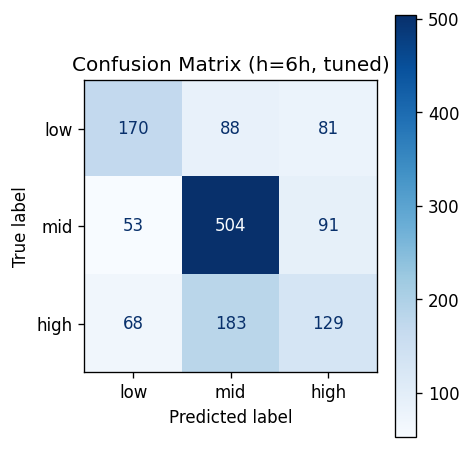

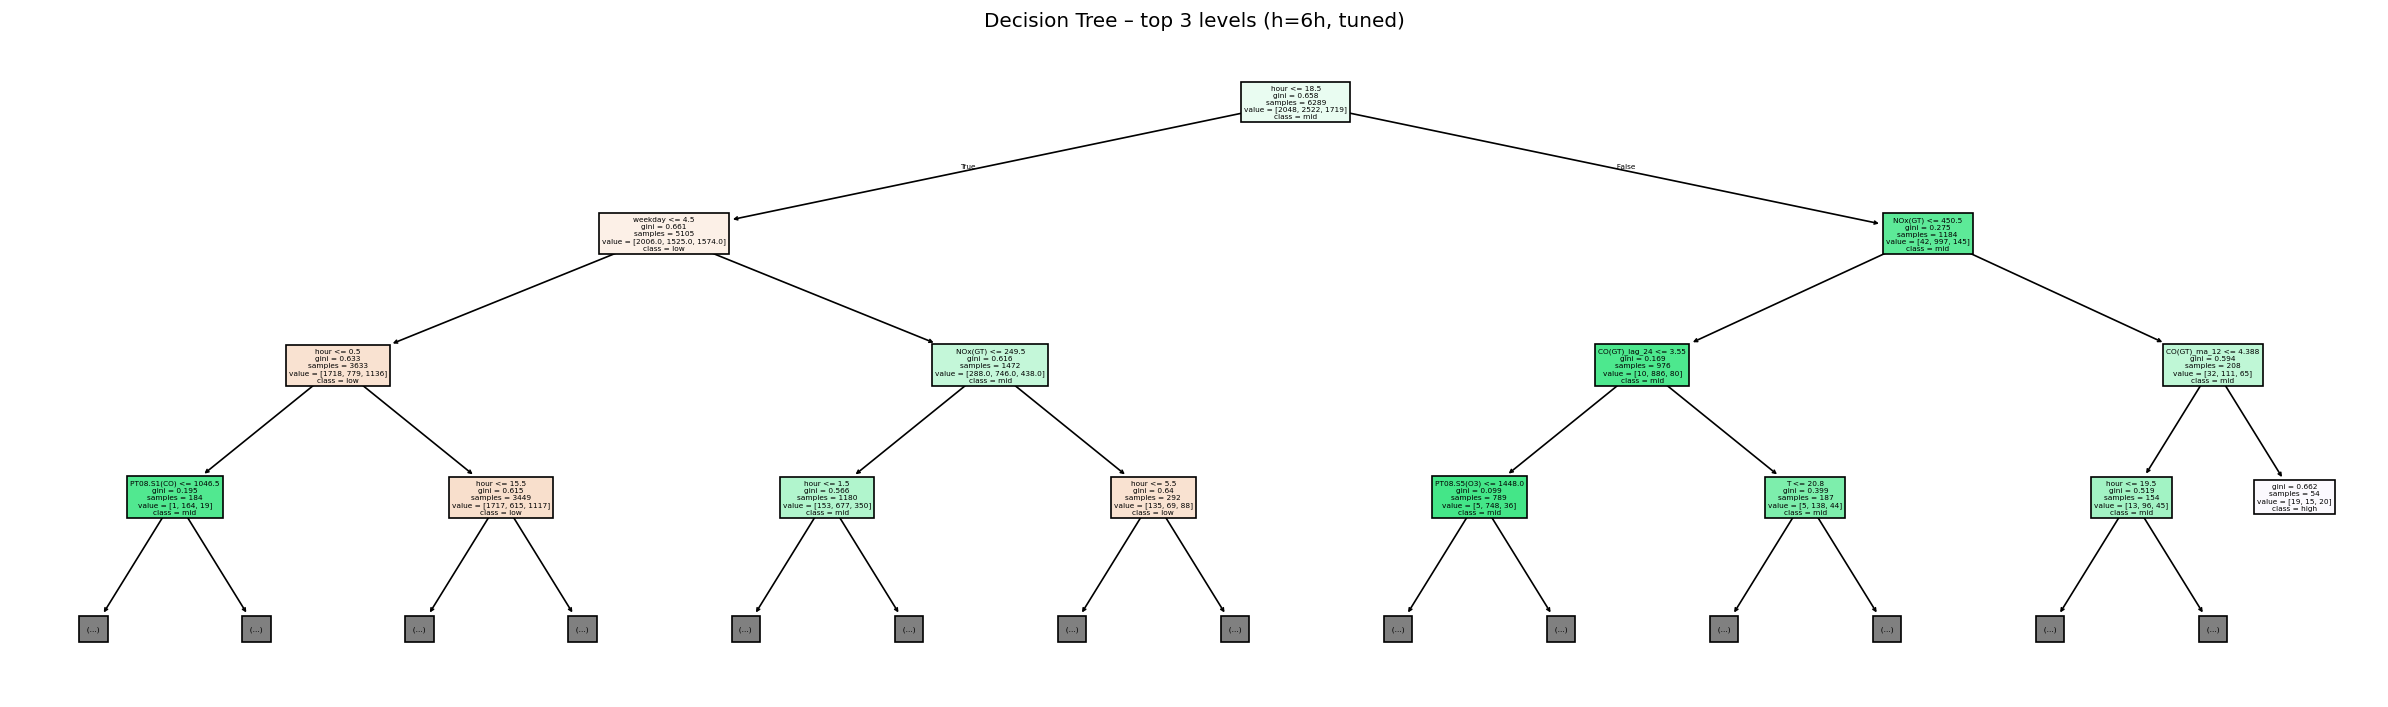


Final model for horizon 12h (max_depth=9, min_samples_leaf=50)
Test accuracy (tuned): 0.6047
Test accuracy (naïve baseline): 0.4009

Classification report (tuned model, test set):
              precision    recall  f1-score   support

        high      0.483     0.735     0.582       339
         low      0.790     0.690     0.736       642
         mid      0.461     0.345     0.395       380

    accuracy                          0.605      1361
   macro avg      0.578     0.590     0.571      1361
weighted avg      0.621     0.605     0.603      1361



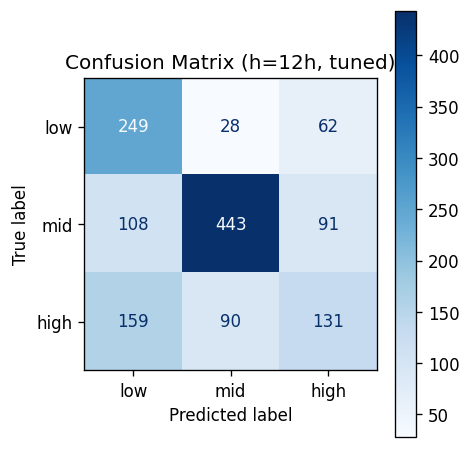

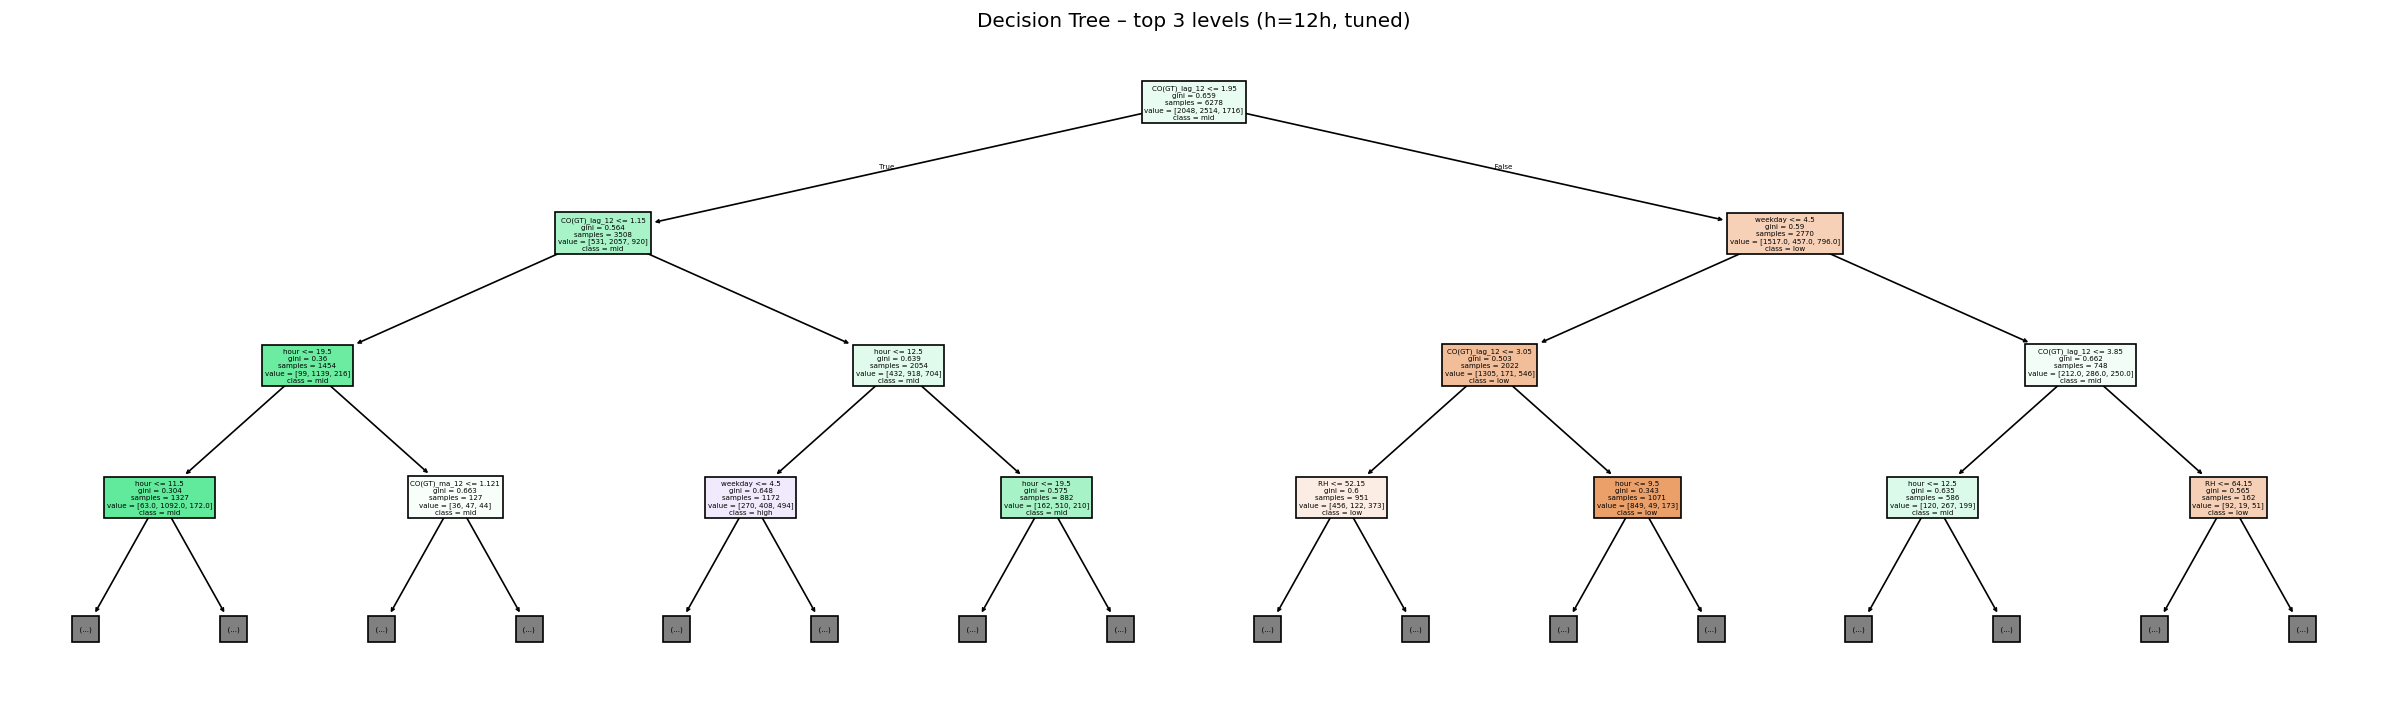


Final model for horizon 24h (max_depth=9, min_samples_leaf=50)
Test accuracy (tuned): 0.6056
Test accuracy (naïve baseline): 0.6275

Classification report (tuned model, test set):
              precision    recall  f1-score   support

        high      0.469     0.814     0.595       339
         low      0.785     0.756     0.770       632
         mid      0.414     0.167     0.238       378

    accuracy                          0.606      1349
   macro avg      0.556     0.579     0.535      1349
weighted avg      0.602     0.606     0.577      1349



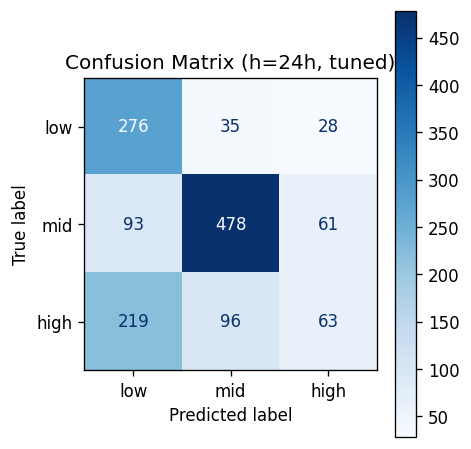

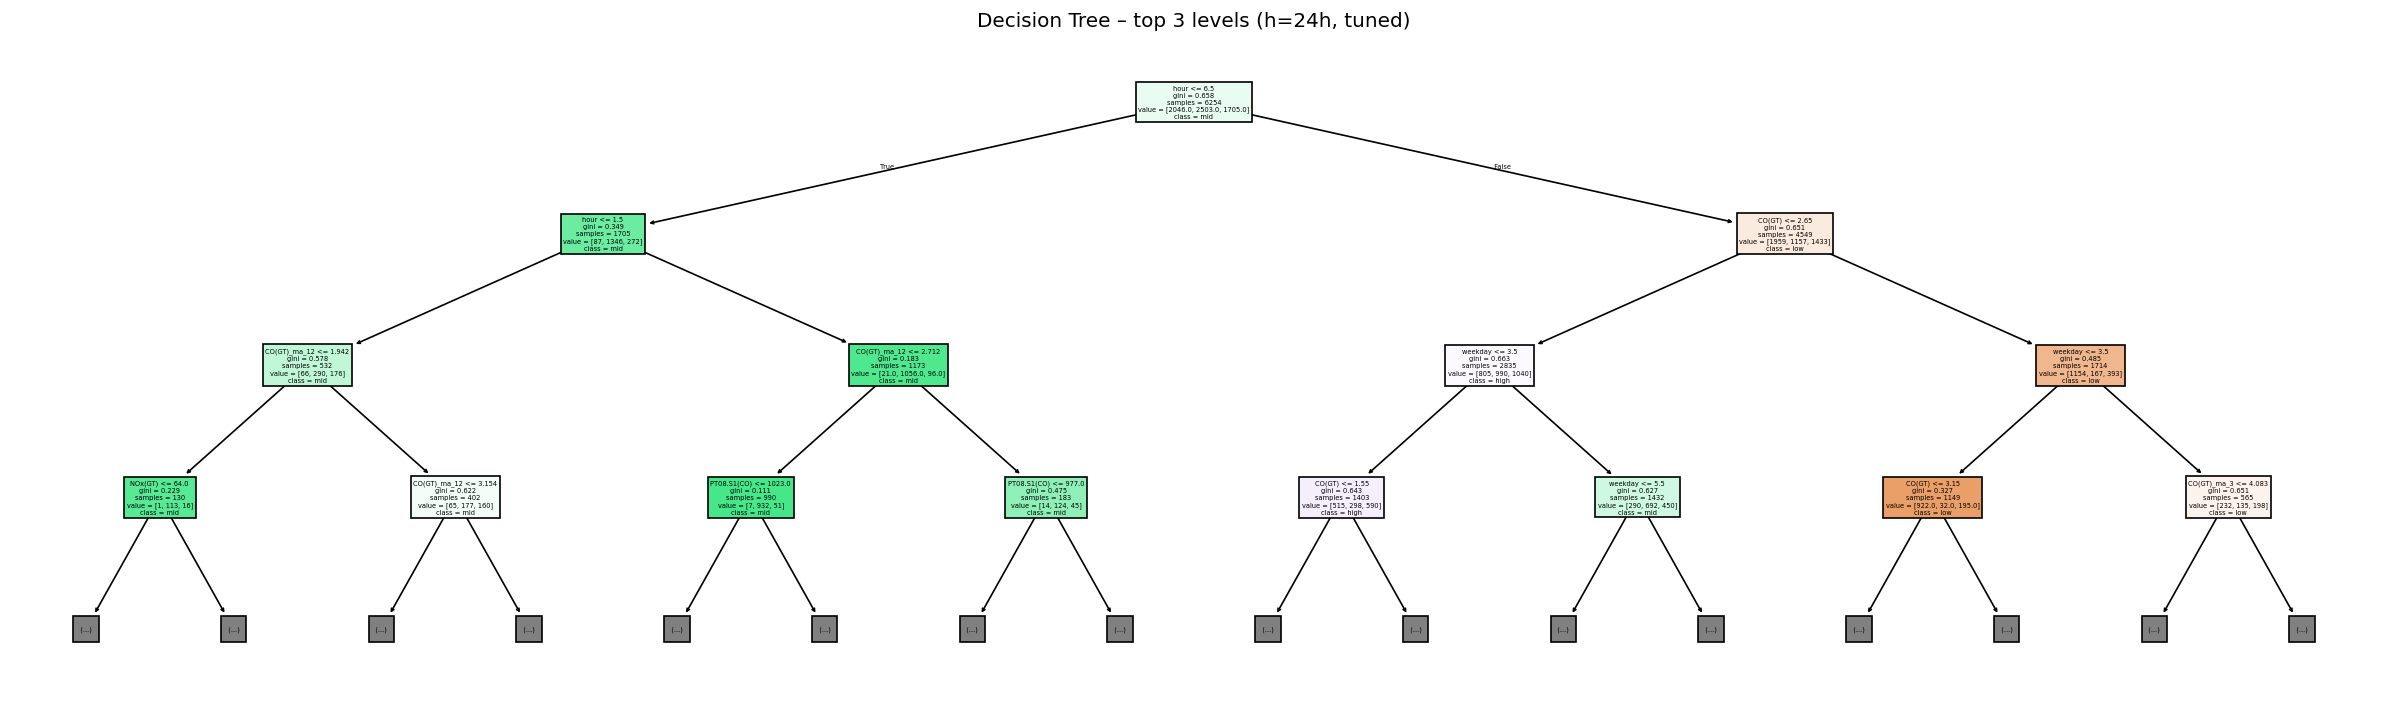

In [ ]:
def run_final_with_params(h: int, depth: int, leaf: int):
    print("\n" + "=" * 60)
    print(f"Final model for horizon {h}h (max_depth={depth}, min_samples_leaf={leaf})")

    Xtr, ytr, feat_cols = build_xy(train, h)
    Xv, yv, _           = build_xy(val,   h)
    Xte, yte, _         = build_xy(test,  h)

    # Combine train + val for final training
    X_train_full = pd.concat([Xtr, Xv], axis=0)
    y_train_full = pd.concat([ytr, yv], axis=0)

    pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("clf", DecisionTreeClassifier(max_depth=depth,
                                        min_samples_leaf=leaf,
                                        random_state=42)),
    ])

    pipe.fit(X_train_full, y_train_full)

    test_pred = pipe.predict(Xte)
    test_acc = accuracy_score(yte, test_pred)
    print(f"Test accuracy (tuned): {test_acc:.4f}")

    co_now = test.loc[Xte.index, TARGET]
    baseline_pred = discretise_co(co_now)
    mask = baseline_pred.notna()
    baseline_acc = accuracy_score(yte[mask], baseline_pred[mask])
    print(f"Test accuracy (naïve baseline): {baseline_acc:.4f}")

    print("\nClassification report (tuned model, test set):")
    print(classification_report(yte, test_pred, digits=3))

    fig, ax = plt.subplots(figsize=(4, 4))
    ConfusionMatrixDisplay.from_predictions(yte, test_pred, ax=ax,
                                            display_labels=["low", "mid", "high"],
                                            cmap="Blues")
    ax.set_title(f"Confusion Matrix (h={h}h, tuned)")
    plt.tight_layout()
    plt.show()

    clf = pipe.named_steps["clf"]
    plt.figure(figsize=(20, 6))
    plot_tree(clf,
              feature_names=feat_cols,
              class_names=["low", "mid", "high"],
              filled=True,
              max_depth=3)
    plt.title(f"Decision Tree – top 3 levels (h={h}h, tuned)")
    plt.tight_layout()
    plt.show()

for h in HORIZONS:
    d, leaf = best_params[h]
    run_final_with_params(h, d, leaf)
